In [23]:
import baltic as bt
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from itertools import combinations

In [25]:
titer_tree = bt.loadJSON('../../data/frequencies/regions/stiffness1/jsons/dengue_all_tree.json', {'name': 'strain', 'height': 'xvalue'})
genotype_tree = bt.loadNexus('../../data/frequencies/regions/stiffness1/global_stiffness1_gtAnnotated_tree.nexus', absoluteTime=False)


Tree height: 0.357550
Tree length: 6.132190
annotations present

Numbers of objects in tree: 2998 (1428 nodes and 1570 leaves)


Tree height: 0.357550
Tree length: 6.132190
multitype tree
annotations present

Numbers of objects in tree: 2999 (1429 nodes and 1570 leaves)



In [29]:
genotype_tips = defaultdict(list)
tip_genotypes = { k.numName : k.traits['genotype'] for k in genotype_tree.leaves if 'genotype' in k.traits}
for k in titer_tree.leaves:
    if k.numName in tip_genotypes:
        k.traits['genotype'] = tip_genotypes[k.numName]
        genotype_tips[k.traits['genotype']].append(k)

In [57]:
def trace_between_nodes(node1, node2):
    '''Naive path tracing; finds mrca of the two nodes, 
    traces each node backwards until it finds the mrca, 
    returns concatenated list of all nodes on that path'''

    assert isinstance(node1, bt.node) and isinstance(node2, bt.node)
    
    node1_trace = []
    node2_trace = []
    
    k = node1 ## Trace from the node 1 to the root (in order)
    while k.index != 'Root':
        node1_trace.append(k)
        k = k.parent
        
    k = node2 ## Start tracing from node2 to the root; break when we find the first node that's shared along node1's path
    while k not in node1_trace:
        node2_trace.append(k)
        k = k.parent
    else:
        node2_trace.append(k)
        mrca = k
        
    node2_trace.reverse() # walk back down from the mrca, so the path is unidirectional
    total_trace = []
    total_trace += node1_trace
    total_trace += node2_trace
    
    return total_trace
    
def collect_attr(trace, attr='dTiter'):
    '''Collects all values of the passed attribute found 
    along the passed path through the tree'''
    return [i.traits[attr] for i in trace]

In [72]:
genotype_mrcas = { gt : titer_tree.commonAncestor(tips, numName=True) for gt, tips in genotype_tips.items() } # MRCA of each genotype
genotype_combinations = [g for g in combinations(genotype_mrcas.keys(), 2)] # Pairs of genotypes

between_genotypes = { (g1,g2): trace_between_nodes(genotype_mrcas[g1], genotype_mrcas[g2]) # Path between each pair of genotype MRCAs
                     for (g1,g2) in genotype_combinations}
genotype_dTiter = { gt: sum(collect_attr(between_genotypes[gt])) for gt in genotype_combinations}
genotype_distance = { gt: sum([ k.height for k in between_genotypes[gt]]) for gt in genotype_combinations}

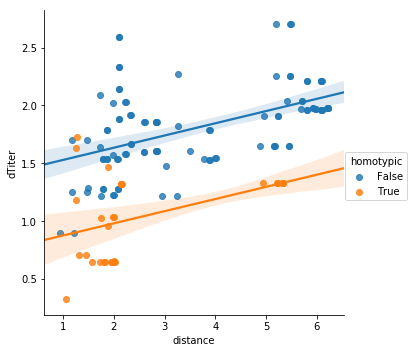

In [65]:
same_serotype = { gt: gt[0].split('_')[0] == gt[1].split('_')[0] for gt in genotype_combinations}
sanity_check = pd.DataFrame({'distance': genotype_distance, 'dTiter': genotype_dTiter, 'homotypic': same_serotype})
sns.lmplot('distance', 'dTiter', hue='homotypic', data=sanity_check)

In [74]:
genotype_dTiter = pd.Series(genotype_dTiter)
genotype_dTiter = genotype_dTiter.reset_index()
genotype_dTiter.to_csv('../../data/katzelnick2015/processed/genotypes_dTiters.csv')